In [1]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

Altri test: least-square fitting, grafo pesato, phase-type distribution (con loss dipendente dai momenti)

Framework per profilazione: Cprofile
Settare numero massimo di core a 1, settare random_seed, macchina dedicata.

### Test 1
``` a = gm([1.], [_mean], [1.]); ```


Genero sample da $\mathcal{N}(10,1)$

In [2]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim1.soga')
cfg = produce_cfg(compiledFile)

In [3]:
pars = {'mean':5.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [4]:
output_dist = start_SOGA(cfg, params_dict)

In [5]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]])>

In [6]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((100,1))

In [7]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [8]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.05)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.050000190734863 loss: 1472.6207275390625
mean: 7.363454818725586 loss: 540.4064331054688
mean: 8.947259902954102 loss: 212.24472045898438
mean: 9.762982368469238 loss: 142.94961547851562
mean: 10.072303771972656 loss: 134.62310791015625
mean: 10.156363487243652 loss: 134.08895874023438
mean: 10.172128677368164 loss: 134.0722198486328
mean: 10.173979759216309 loss: 134.072021484375
mean: 10.174071311950684 loss: 134.072021484375
mean: 10.174071311950684 loss: 134.072021484375


In [9]:
sampling_mean

tensor(10.)

In [10]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(135.5870)
Likelihood in the optimized distribution:  tensor(134.0720, grad_fn=<NegBackward0>)


### Test 2

``` a = gm([1.], [10.], [_std]);  ```

In [11]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim2.soga')
cfg = produce_cfg(compiledFile)

In [12]:
pars = {'std':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [13]:
output_dist = start_SOGA(cfg, params_dict)

In [14]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[10.]])
sigma: tensor([[[4.]]], grad_fn=<IndexBackward0>)>

In [15]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(0.9990)


In [16]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


std: 1.9900000095367432 loss: 1736.710693359375
std: 1.4888683557510376 loss: 1545.5096435546875
std: 1.0656424760818481 loss: 1422.1549072265625
std: 0.9943690299987793 loss: 1417.4569091796875
std: 0.9985961318016052 loss: 1417.435791015625
std: 0.9985181093215942 loss: 1417.435791015625
std: 0.9984966516494751 loss: 1417.4356689453125
std: 0.9984983801841736 loss: 1417.435791015625
std: 0.9984983801841736 loss: 1417.435791015625
std: 0.9984983801841736 loss: 1417.435791015625


In [17]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1417.4380)
Likelihood in the optimized distribution:  tensor(1417.4358, grad_fn=<NegBackward0>)


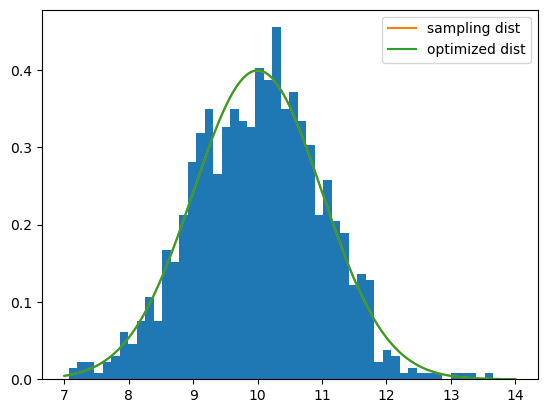

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(7,14,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 3

```
a = gm([1.], [1.], [1.]);
a = _par1 * a + 1.;
```

sample from the program with _par1 = 2

In [19]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [20]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim3.soga')
cfg = produce_cfg(compiledFile)

In [21]:
pars = {'par1':1.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [22]:
output_dist = start_SOGA(cfg, params_dict)

In [23]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[1.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]]], grad_fn=<IndexBackward0>)>

In [24]:
sampling_mean = torch.tensor(2.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [25]:
torch.var(samples)

tensor(3.9239)

In [26]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [27]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par1: 1.0099999904632568 loss: 3451.31201171875
par1: 1.4073612689971924 loss: 2367.69677734375
par1: 1.6124712228775024 loss: 2192.4716796875
par1: 1.738662600517273 loss: 2139.19970703125
par1: 1.8241997957229614 loss: 2118.404052734375
par1: 1.883842945098877 loss: 2109.53125
par1: 1.9256463050842285 loss: 2105.625244140625
par1: 1.9547475576400757 loss: 2103.904541015625
par1: 1.9747120141983032 loss: 2103.160400390625
par1: 1.9881324768066406 loss: 2102.84912109375


In [28]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2102.6943)
Likelihood in the optimized distribution:  tensor(2102.7241, grad_fn=<NegBackward0>)


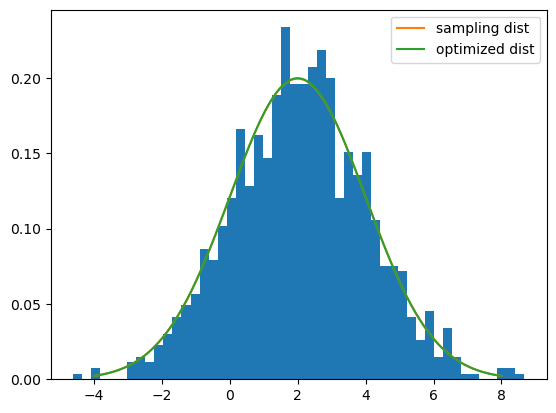

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-4,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 4

```
a = gm([1.], [1.], [1.]);
a = 2 * a + _par2;
```

sample from the program with _par2 = 1

In [30]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [31]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim4.soga')
cfg = produce_cfg(compiledFile)

In [32]:
pars = {'par2':2.}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [33]:
output_dist = start_SOGA(cfg, params_dict)

In [34]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[4.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[4.]]])>

In [35]:
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))

In [36]:
torch.var(samples)

tensor(4.0975)

In [37]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.001)

for i in range(500):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 50 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


par2: 1.9989999532699585 loss: 2241.104248046875
par2: 1.9493328332901 loss: 2229.378662109375
par2: 1.900844693183899 loss: 2218.524169921875
par2: 1.8536834716796875 loss: 2208.53125
par2: 1.8078646659851074 loss: 2199.35546875
par2: 1.7634023427963257 loss: 2190.95361328125
par2: 1.7203097343444824 loss: 2183.28271484375
par2: 1.678600549697876 loss: 2176.30029296875
par2: 1.63828706741333 loss: 2169.965576171875
par2: 1.599381923675537 loss: 2164.237548828125


In [38]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([1.]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(2123.8853)
Likelihood in the optimized distribution:  tensor(2159.0769, grad_fn=<NegBackward0>)


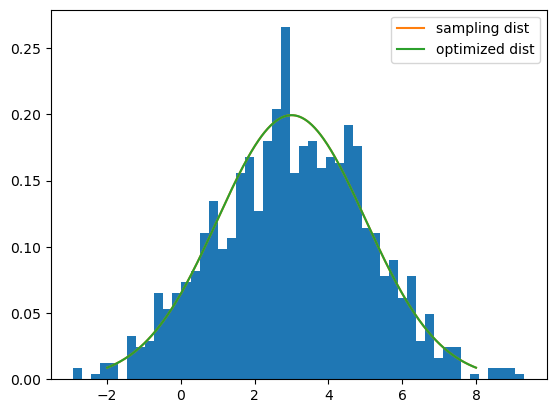

In [39]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = np.linspace(-2,8,500)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), np.sqrt(output_dist.gm.sigma[0][0,0].item())).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 5

``` 
if gm([1.], [_mean], [1.]) < 0 {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _mean = 0

In [40]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [41]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim5.soga')
cfg = produce_cfg(compiledFile)

In [42]:
cfg.node_list

{'entry': EntryNode<>,
 'test0': TestNode<test0,gm([1.],[_mean],[1.])<0>,
 'state0': StateNode<state0,True,a=gm([1.],[-5.],[1.])>,
 'state1': StateNode<state1,False,a=gm([1.],[5.],[1.])>,
 'merge0': MergeNode<merge0>,
 'exit': ExitNode<>}

In [43]:
pars = {'mean':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [44]:
output_dist = start_SOGA(cfg, params_dict)

In [45]:
output_dist

Dist<['a'],pi: tensor([[0.3085],
        [0.6915]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [46]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

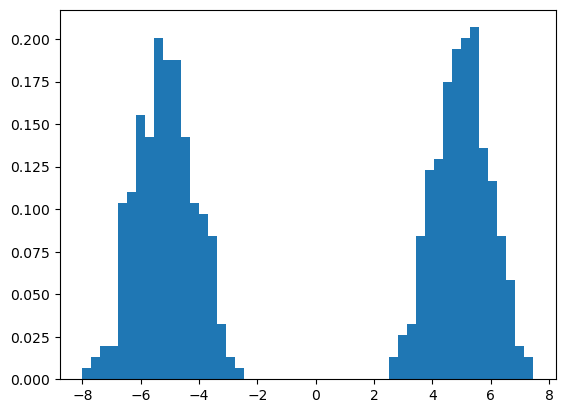

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [48]:
def neg_likelihood(dist, samples, idx=0):
    likelihood = dist.gm.marg_pdf(samples,idx)
    log_likelihood = torch.log(likelihood)
    return -torch.sum(log_likelihood)

In [49]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)

    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 0.49000000953674316 loss: 1085.602294921875
mean: 0.21195834875106812 loss: 1053.197265625
mean: 0.0426306426525116 loss: 1045.5653076171875
mean: -0.006587787065654993 loss: 1045.150634765625
mean: -0.007241962943226099 loss: 1045.151123046875
mean: -0.004906479734927416 loss: 1045.1502685546875
mean: -0.004929471295326948 loss: 1045.150390625
mean: -0.005029682070016861 loss: 1045.1502685546875
mean: -0.005013538058847189 loss: 1045.1502685546875
mean: -0.005012548062950373 loss: 1045.150390625


In [50]:
current_dist

Dist<['a'],pi: tensor([[0.5020],
        [0.4980]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [51]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1045.1543)
Likelihood in the optimized distribution:  tensor(1045.1503, grad_fn=<NegBackward0>)


In [52]:
output_dist

Dist<['a'],pi: tensor([[0.5020],
        [0.4980]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

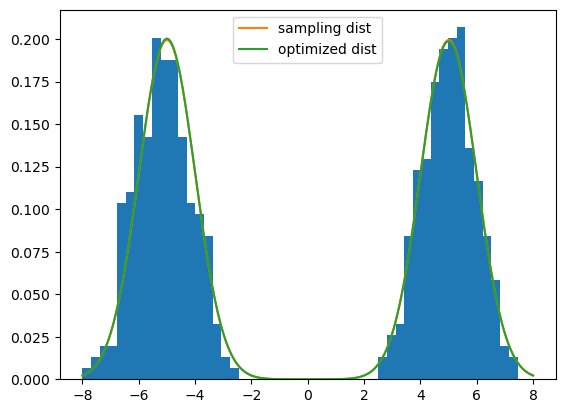

In [53]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 6

``` 
if gm([1.], [0.], [1.]) < _coeff {
    a = gm([1.], [-5.], [1.]);
} else {
    a = gm([1.], [5.], [1.]);
} end if;
```

sample from the program with _coeff = 0

In [54]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [55]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim6.soga')
cfg = produce_cfg(compiledFile)

In [56]:
pars = {'coeff':0.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [57]:
output_dist = start_SOGA(cfg, params_dict)

In [58]:
output_dist

Dist<['a'],pi: tensor([[0.6915],
        [0.3085]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

In [59]:
sampling_pi = torch.tensor(0.5)
sampling_mean = torch.tensor(3.)
sampling_std = torch.tensor(2.)

samples = torch.zeros((500,1))
latent = distributions.Bernoulli(sampling_pi).sample(samples.shape)
for i, r in enumerate(latent):
    if r:
        samples[i] = distributions.Normal(torch.tensor(-5.), torch.tensor(1.)).sample((1,))
    else:
        samples[i] = distributions.Normal(torch.tensor(5.), torch.tensor(1.)).sample((1,))

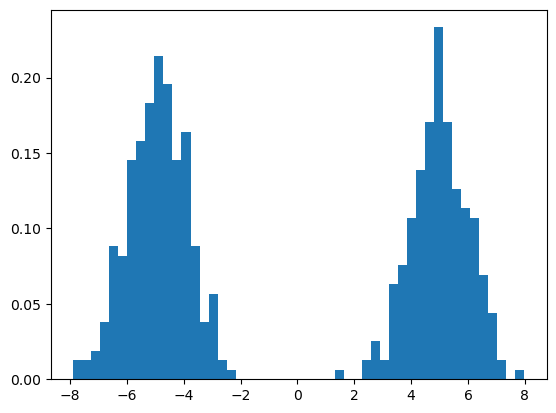

In [60]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

In [61]:
import torch

#pars = {'mean':2.}
#
## creates torch parameters for each params declared in the dictionary
#params_dict = {}
#for key, value in pars.items():
#    params_dict[key] = torch.tensor(value, requires_grad=True)    

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(300):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 30 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


coeff: 0.49000000953674316 loss: 1097.3162841796875
coeff: 0.216828390955925 loss: 1071.50341796875
coeff: 0.07641594856977463 loss: 1067.5179443359375
coeff: 0.058830514550209045 loss: 1067.49658203125
coeff: 0.06522510945796967 loss: 1067.4896240234375
coeff: 0.06547532230615616 loss: 1067.48974609375
coeff: 0.06516237556934357 loss: 1067.48974609375
coeff: 0.06522352248430252 loss: 1067.4896240234375
coeff: 0.06521913409233093 loss: 1067.4896240234375
coeff: 0.06521814316511154 loss: 1067.48974609375


In [62]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[0.5], [0.5]]), torch.tensor([[-5.], [5.]]), torch.tensor([[[1.]], [[1.]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples, idx=0))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples, idx=0))

Likelihood with respect to the sampling distribution:  tensor(1068.1660)
Likelihood in the optimized distribution:  tensor(1067.4897, grad_fn=<NegBackward0>)


In [63]:
output_dist

Dist<['a'],pi: tensor([[0.5260],
        [0.4740]], grad_fn=<DivBackward0>)
mu: tensor([[-5.],
        [ 5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[1.]],

        [[1.]]], grad_fn=<IndexBackward0>)>

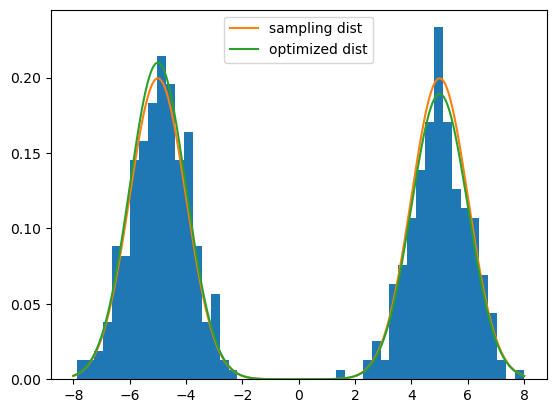

In [64]:
import matplotlib.pyplot as plt
from scipy.stats import norm


npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(-8,8,500).view(-1,1)
y_sampling = sampling_dist.gm.marg_pdf(x, 0)
y_optim = output_dist.gm.marg_pdf(x, 0).detach()

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()

### TEST 7

``` 
a = gm([1.], [_mean], [_std]); 
```

In [65]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

In [66]:
compiledFile=compile2SOGA('../programs/SOGA/Optimization/Optim7.soga')
cfg = produce_cfg(compiledFile)

In [67]:
pars = {'mean':5., 'std':2.5}

# creates torch parameters for each params declared in the dictionary
params_dict = {}
for key, value in pars.items():
    params_dict[key] = torch.tensor(value, requires_grad=True)    

In [68]:
output_dist = start_SOGA(cfg, params_dict)

In [69]:
output_dist

Dist<['a'],pi: tensor([[1.]])
mu: tensor([[5.]], grad_fn=<IndexBackward0>)
sigma: tensor([[[6.2500]]], grad_fn=<IndexBackward0>)>

In [70]:
sampling_mean = torch.tensor(10.)
sampling_std = torch.tensor(1.)
samples = distributions.Normal(sampling_mean, sampling_std).sample((1000,1))
print('samples std', torch.std(samples))

samples std tensor(1.0003)


In [71]:
import torch

# Define the optimizer with init_mean as the parameter

optimizer = torch.optim.Adam([params_dict[key] for key in params_dict.keys()], lr=0.01)

for i in range(1000):
    optimizer.zero_grad()  # Reset gradients
    
    # loss
    #current_dist = compute_posterior(init_mean)
    current_dist = start_SOGA(cfg, params_dict)
    loss = neg_likelihood(current_dist, samples)
    
    # Backpropagate
    loss.backward()
    
    # Update init_mean
    optimizer.step()

    #with torch.no_grad():
    #    params_dict['std'].clamp_(0.001, 1e10)
    
    # Print progress
    if i % 100 == 0:
        out = ''
        for key in params_dict.keys():
            out = out + key + ': ' + str(params_dict[key].item())
        out = out + f" loss: {loss.item()}"
        print(out)


mean: 5.010000228881836std: 2.509999990463257 loss: 3850.37646484375
mean: 5.880498886108398std: 3.2167255878448486 loss: 2927.21728515625
mean: 6.570565700531006std: 3.4309113025665283 loss: 2672.138916015625
mean: 7.205822467803955std: 3.3526289463043213 loss: 2502.1103515625
mean: 7.839671611785889std: 3.0273489952087402 loss: 2318.973388671875
mean: 8.516663551330566std: 2.4409573078155518 loss: 2063.26806640625
mean: 9.292523384094238std: 1.5492836236953735 loss: 1651.482421875
mean: 9.899612426757812std: 0.9965538382530212 loss: 1418.9998779296875
mean: 9.918380737304688std: 0.9998518228530884 loss: 1418.7840576171875
mean: 9.918290138244629std: 0.9998456239700317 loss: 1418.783935546875


In [72]:
sampling_dist = Dist(['x'], GaussianMix(torch.tensor([[1.]]), torch.tensor([[sampling_mean.item()]]), torch.tensor([[[sampling_std.item()**2]]])))
print('Likelihood with respect to the sampling distribution: ', neg_likelihood(sampling_dist, samples))
output_dist = start_SOGA(cfg, params_dict)
print('Likelihood in the optimized distribution: ', neg_likelihood(output_dist, samples))

Likelihood with respect to the sampling distribution:  tensor(1422.1217)
Likelihood in the optimized distribution:  tensor(1418.7839, grad_fn=<NegBackward0>)


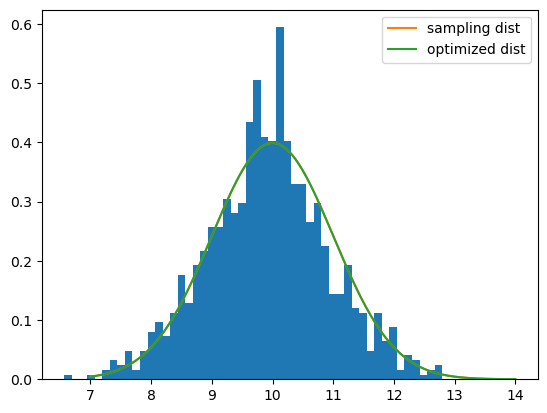

In [73]:
import matplotlib.pyplot as plt
from scipy.stats import norm

npsamples = np.array([sample.item() for sample in samples])
_ = plt.hist(npsamples, bins=50, density=True)

x = torch.linspace(7,14,500).view(-1,1)
y_sampling = norm(sampling_mean.item(), sampling_std.item()).pdf(x)
y_optim = norm(sampling_mean.item(), params_dict['std'].item()).pdf(x)

plt.plot(x, y_sampling, label='sampling dist')
plt.plot(x, y_optim, label='optimized dist')
plt.legend()